# Development and Design of an Automatic Test Bench for Robot Motors
__DEPARTMENT OF INFORMATICS__

__TECHNISCHE UNIVERSITÄT MÜNCHEN__

Semester thesis<br>
Ferdinand Elhardt<br>
15 October 2020<br>
Supervisor: Prof. Dr.-Ing. habil. Alois Christian Knoll<br>
Advisor: Paul Maroldt, Martin Riedel<br>

This document contains the calculations for the design of the test bench including dynamics analysis. The process of development is described in the semester thesis with the same title.
<img src="img/test_rig.png" width="800">

## Import

In [1]:
# Do not change this part.
import numpy as np
import scipy as sp
from scipy import linalg
from matplotlib import pyplot as plt

## Machanical System of the Test Bench
<img src="img/System_Abmessungen_2.png" width="800">

As we have developed the concepts, we present the general setup of the test bench. Figure \ref{fig:designconcept} shows a draft of the hardware's structural layout. The motor module is the test object which creates the torque and accelerates and decelerates the system. A flange connects the motor module with a continuous shaft. The incremental angle encoder is mounted with a hollow shaft on the continuous shaft. In order to compensate lateral, axial and angular shaft misalignment, the torque sensor has a coupling mounted which connects it to the continuous shaft. Between flywheel and torque sensor, there is another coupling that transmits the torque.

### Spring Mass System

<img src="img/spring_mass_system.jpg" width="800">

In order to analyze the system, we reduce the system to the following spring mass system as shown in figure \ref{fig:spring_mass_system}. We illustrate the axis as springs and neglect their inertia because the radius is small comparative to the other components and thus the inertia is low, too. The couplings are expressed as point masses without spring behavior. This is valid because $ k_{coupling} >> k_{a} $. We illustrate the torque sensor as two point masses which and a spring in between. The two flywheels are simplified as two point masses located at the end of the system.

## Defintion of the Components
This section describes the relevant attributes of the components. We will use them later to run a static and dynamic analysis of the mechanical system. Providing the eigenfrequencies and eigenmodes, this gives us an understanding of the system dynamics.

### Motor Module
The relevant properties of the motor module depend on the implemented motor and gear. The motor has a rotational speed and a torque. The gear has a ratio and a maximum permitted speed. Thus, the complete motor module has a maximum torque which is $\tau = \tau_{motor}/r_{gear}$. The maximum speed of the motormodule is limited by the motor speed (multiplied with the gear ratio) or by the maximum permitted gear speed. Therefore, the speed of the motor module is $\dot{\theta} = min(\dot{\theta}_{motor}/r_{gear}, \dot{\theta}_{gear, max})$.

In [2]:
class Motor:  # this class describes the build-in motors in the motormodules
    def __init__(self, name, rpm, torque, inertia):
        self.name = name   # [string] name of motor
        self.rpm = rpm     # [U/min] rotational speed of motor
        self.torque = torque   # [Nm] torque of motor
        self.inertia = inertia  # [kg/m^2] inertia of rotor

class Gear:  # describes the gear in the motormodule
    def __init__(self, name, ratio, rpm):
        self.name = name
        self.ratio = ratio
        self.rpm = rpm     # max Rotation at Output (slower)

class Motormodule:  # describes the motormodule itself
    def __init__(self, name, motor, gear, max_def, inertia):
        self.name = name
        self.motor = motor
        self.gear = gear
        self.max_deflection = max_def   # [rad]
    @property
    def torque(self):    # [Nm] maximum torque of the motormodule without considering friction
        return self.motor.torque*self.gear.ratio
    @property
    def speed_rpm(self):   # [rpm] maximum speed of the motormodule (either motor or gear) without considering friction
        return min(self.motor.rpm/self.gear.ratio, self.gear.rpm)
    @property
    def speed_rad(self):  # [rad/s] maximum speed of the motormodule without considering friction
        return self.speed_rpm*2*np.pi/60
    @property
    def inertia(self):    # [kg m^2] inertia of the motor module
        return self.motor.inertia*self.gear.ratio

motor85 = Motor("ILM 85x13", 2950,  1.440, 0.6100*10**-4)
motor70 = Motor("ILM 70x10", 3650,  0.660, 0.1960*10**-4)
motor50 = Motor("ILM 50x14", 3870,  0.540, 0.0900*10**-4)
motor38 = Motor("ILM 38x12", 10190, 0.234, 0.0203*10**-4)

gear160 = Gear("CPL-20A-160-2A", 160, 40.625)
gear120 = Gear("CPL-17A-120-2A", 120, 60.8333)

motormodule_XL = Motormodule("Motormodule XL", motor85, gear160, 2*np.pi, 15*10**-3)
motormodule_L = Motormodule ("Motormodule L",  motor70, gear160, 2*np.pi, 13*10**-3)
motormodule_M = Motormodule ("Motormodule M",  motor50, gear120, 2*np.pi, 11*10**-3)
motormodule_S = Motormodule ("Motormodule S",  motor38, gear120, 2*np.pi, 9*10**-3)

In [3]:
motormodule_S.speed_rpm

60.8333

### Axis
We define the properties of the axis including geometry and the material's shear modulus. Additionally, we set methods to calculate the moment of area, the spring constant and the moment of inertia. 

The spring constant $k_\phi$ of the axis is 

$$k_{\phi, axis} = \frac{G J_T}{L}$$

The lenght is depicted with $L$, the shear modulus is $G$ and the moment of area is $J_T$. Using the formula for cylindric geometry, we come to:

$$ J_T = \frac{\pi d^4}{32} $$ in \si{\radian\per\newton\meter}


In [4]:
class Axis:
    def __init__(self, material, shear_modulus, length, diameter):
        self.material = material
        self.shear_modulus = shear_modulus # [N/mm^2] Schubmodul
        self.length = length # [m] Länge der Welle
        self.diameter = diameter # [m] Diameter of the axis
    @property
    def moment_of_area(self):
        return np.pi*self.diameter**4/32    # [kg m^2]
    @property
    def inertia(self):
        return np.pi*self.diameter**4/32    # [kg m^2]
    @property
    def spring_constant(self):
        return (self.shear_modulus*10**6)*self.moment_of_area/self.length   # [Nm/rad]
    def torsion(self, tau):
        return tau/self.spring_constant     # [rad]
        
axis = Axis(material="steel", shear_modulus=80000, length=0.250, diameter = 0.042) # 80000 shear modulus

print("axis.moment_of_area = {0:.10f} Kg m^2".format(axis.moment_of_area))
print("axis.spring_constant= {0:.10f} rad/Nm".format(axis.spring_constant))
print("torsion at 230Nm = {0:.5f} rad".format(axis.torsion(230)))

axis.moment_of_area = 0.0000003055 Kg m^2
axis.spring_constant= 97756.8129380475 rad/Nm
torsion at 230Nm = 0.00235 rad


### Coupling
The coupling has a moment of inertia $J_{coupling}$ and a spring constant $K_{coupling}$ which contribute to the dynamics of the system. We retrieve this values from \footfullcite{mikipulley}.

In [5]:
class Coupling:
    def __init__(self, inertia, spring_constant):
        self.inertia = inertia # [kg m^2] Trägheitsmoment
        self.spring_constant = spring_constant     # [Nm/rad] Torsionssteifigkeit
    def torsion(self, tau):
        return tau/self.spring_constant

coupling = Coupling(inertia=14.68*10**-3, spring_constant=700000)

### Encoder
The encoder only contributes to the dynamics with its inertia $J_{encoder}$. We neglect this inertia, because comparing to the other components on the test bench, this contribution to the system dynamics is very small. The spring constant is irrelvant because it is mounted with a hollow shaft and thus does not transmit any torque. The encoder features a number of position values per revolution $p_{angle}$. Every position value results in an impulse which is transmitted to the \emph{information processing system}. The critical factor is the number of impulses per seconds. This deducts another demand as it must be able to process this information at the maximum possible rotation speed of the motor modules in real time requirements.

In [6]:
class Encoder:
    def __init__(self, inertia, resolution):
        self.inertia = inertia  # [kgm^2] Trägheitsmoment
        self.resolution = resolution     # [-] total Resolution per Rotation
    def impulses_per_second(self, rpm):
        return self.resolution*rpm/60
    
encoder = Encoder(inertia=0, resolution=500000)

print("Impulse rate transmitted to the information processing system: {0:.1f} per second".\
      format(encoder.impulses_per_second(motormodule_S.speed_rpm)))

Impulse rate transmitted to the information processing system: 506944.2 per second


### Torque Sensor
The torque sensor is described with a spring constant $K_{torque}$. The inertia is distributed on the drive side $J_{torque, drive}$. and measurment side $J_{torque, measurement}$. The shaft which has the spring behaviour is in between. This let us determine the dynamics of the torque sensor.

In [7]:
class Torque_sensor:
    def __init__(self, spring_constant, inertia_drive, inertia_measure):
        self.spring_constant = spring_constant   # [Nm/rad] Federsteifigkeit, DR-2643
        self.inertia_drive = inertia_drive  # [kg m^2] Trägheitsmoment, DR-2643 Antriebsseite
        self.inertia_measure = inertia_measure  # [kg m^2] Trägheitsmoment, DR-2643 Messseite
    def torsion(self, tau):
        return tau/self.spring_constant
    @property
    def inertia(self):  # [kg m^2] the total moment of inertia is the sum
        return self.inertia_measure + self.inertia_drive
    
torque_sensor = Torque_sensor(spring_constant=170000, inertia_drive=6.4e-4, inertia_measure=6.4e-4)

### Flywheel

The flywheel's job is to simulate the inertia of a robotic joint. It can be described by the radius and it has a moment of inertia that shapes the complete system dynamics. We can mount two flywheels on the system in order to be able to adjust the moment of inertia according to the desired dynamics for the test procedures. The load defines the total moment of inertia of the complete system, including the axis and the two (or one, depeding on the configuration) flywheels.

In [8]:
class Flywheel:
    def __init__(self, inertia, mass, radius):
        self.inertia = inertia   # [kg m^2] moment of inertia
        self.mass = mass     # [kg] mass
        self.radius = radius    # [m] radius of the flywheel

flywheel_big = Flywheel(inertia = 1.87, mass = 36.7, radius = 0.304)  # 1.87
flywheel_small = Flywheel(inertia = 0.8, mass = 32.9, radius = 0.202) # 0.8
axis_flywheel = Axis(material="steel", shear_modulus=80000, length=0.270, diameter = 0.050)
axis_flywheel_inter = Axis(material="steel", shear_modulus=80000, length=0.180, diameter = 0.050)

print("flywheel_big.mass = {0:.2f} kg".format(flywheel_big.mass))
print("flywheel_big.inertia = {0:.2f} kg m^2".format(flywheel_big.inertia))
print("flywheel_big.radius = {0:.3f} m".format(flywheel_big.radius))
print("flywheel_small.mass = {0:.2f} kg".format(flywheel_small.mass))
print("flywheel_small.inertia = {0:.2f} kg m^2".format(flywheel_small.inertia))
print("flywheel_small.radius = {0:.3f} m".format(flywheel_small.radius))
print("axis_flywheel.spring_constant = {0:.8f} kg m^2".format(axis_flywheel.spring_constant))
print("axis_flywheel_inter.spring_constant = {0:.8f} kg m^2".format(axis_flywheel_inter.spring_constant))

flywheel_big.mass = 36.70 kg
flywheel_big.inertia = 1.87 kg m^2
flywheel_big.radius = 0.304 m
flywheel_small.mass = 32.90 kg
flywheel_small.inertia = 0.80 kg m^2
flywheel_small.radius = 0.202 m
axis_flywheel.spring_constant = 181805.13041608 kg m^2
axis_flywheel_inter.spring_constant = 272707.69562411 kg m^2


### Real Time Computer (PLC)
We need to ensure that the real time computer is capable to read the high frequency sensor values and is able to provide enough data points in one measurement procedure. This depends on the so called cycle time of the computer. This is the time period which is needed for reading, processing and writing the sensor data. The shorter the cycle time, the higher the sampling rate of the test bench. This results in more data points and thus a higher resolution. Running the motor modules with highest acceleration possible, they possible reach its highest permitted velocity in relatively short time period. Especially for these testing procedure, a high temporal resolution dramatically helps to produce valuable data sets.

In [9]:
class PLC:
    def __init__(self, name, cycletime_us, distributedclock_us):
        self.name = name
        self.cycletime_us = cycletime_us    # [µs]
        self.cycletime_s = cycletime_us*0.000001   # [s] cycletime in seconds
        self.distributedclock_us = distributedclock_us
        self.distributedclock_s = distributedclock_us*0.000001   # [s] distributed clock in seconds
PLC_laptop = PLC("PLC_laptop", 1000, 100)  # 1ms cycletime is 1000µs, distributed clock is facor 10 -> 100µs

## Analysis of the Mechanical System
### System with one big Flywheel
$$ M \ddot{\theta} + K \theta = f $$
with
$$ M = \begin{bmatrix}
J_{coupling} & 0 & 0 & 0 & 0\\
0 & J_{torque, drive} & 0 & 0 & 0\\
0 & 0 & J_{torque, measure} & 0 & 0\\
0 & 0 & 0 & J_{coupling} & 0\\
0 & 0 & 0 & 0 & J_{flywheel, big}\\
\end{bmatrix}
$$

$$ K = \begin{bmatrix}
k_{a}+k_{c} & -k_{c} & 0 & 0 & 0\\
-k_{c} & k_{c}+k_{t} & -k_{t} & 0 & 0\\
0 & -k_{t} & k_{t}+k_{c} & -k_{c} & 0\\
0 & 0 & -k_{c} & k_{c}+k_{a, f} & -k_{a, f}\\
0 & 0 & 0 & -k_{a, f} & k_{a, f}\\
\end{bmatrix}
$$

$$ f = \begin{bmatrix}
0\\
0\\
0\\
0\\
\tau_{ex}\\
\end{bmatrix}
$$


In [10]:
M = np.diag([coupling.inertia, torque_sensor.inertia_drive, torque_sensor.inertia_measure, \
         coupling.inertia, flywheel_big.inertia])
K = np.matrix([[axis.spring_constant + coupling.spring_constant, -coupling.spring_constant, 0, 0, 0],\
    [-coupling.spring_constant, coupling.spring_constant+torque_sensor.spring_constant, -torque_sensor.spring_constant, 0, 0],\
    [0, -torque_sensor.spring_constant, torque_sensor.spring_constant+coupling.spring_constant, -coupling.spring_constant, 0],\
    [0, 0, -coupling.spring_constant, coupling.spring_constant+axis_flywheel.spring_constant, -axis_flywheel.spring_constant],\
    [0, 0, 0, -axis_flywheel.spring_constant, axis_flywheel.spring_constant]])
f = np.matrix([[0],[0],[0],[0],[0]])
print(M)
print(K)
print(f)

[[1.468e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 6.400e-04 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 6.400e-04 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.468e-02 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.870e+00]]
[[ 797756.81293805 -700000.               0.               0.
        0.        ]
 [-700000.          870000.         -170000.               0.
        0.        ]
 [      0.         -170000.          870000.         -700000.
        0.        ]
 [      0.               0.         -700000.          881805.13041608
  -181805.13041608]
 [      0.               0.               0.         -181805.13041608
   181805.13041608]]
[[0]
 [0]
 [0]
 [0]
 [0]]


### Extended System with two flywheels
$$ M \ddot{\theta} + K \theta = f $$
with
$$ M_{ex} = \begin{bmatrix}
J_{coupling} & 0 & 0 & 0 & 0 & 0\\
0 & J_{torque, drive} & 0 & 0 & 0 & 0\\
0 & 0 & J_{torque, measure} & 0 & 0 & 0\\
0 & 0 & 0 & J_{coupling} & 0 & 0\\
0 & 0 & 0 & 0 & J_{flywheel, big} & 0\\
0 & 0 & 0 & 0 & 0 & J_{flywheel, small}\\
\end{bmatrix}
$$

$$ K_{ex} = \begin{bmatrix}
k_{a}+k_{c} & -k_{c} & 0 & 0 & 0 & 0\\
-k_{c} & k_{c}+k_{t} & -k_{t} & 0 & 0 & 0\\
0 & -k_{t} & k_{t}+k_{c} & -k_{c} & 0 & 0\\
0 & 0 & -k_{c} & k_{c}+k_{a, f} & -k_{a, f} & 0\\
0 & 0 & 0 & -k_{a, f} & k_{a, f}+k_{a,f,i} & -k_{a,f,i}\\
0 & 0 & 0 & 0 & -k_{a,f,i} & k_{a,f,i}\\
\end{bmatrix}
$$

$$ f_{ex} = \begin{bmatrix}
0\\
0\\
0\\
0\\
0\\
\tau_{ex}\\
\end{bmatrix}
$$


In [11]:
M_ex = np.diag([coupling.inertia, torque_sensor.inertia_drive, torque_sensor.inertia_measure, \
         coupling.inertia, flywheel_big.inertia, flywheel_small.inertia])
K_ex = np.matrix([[axis.spring_constant + coupling.spring_constant, -coupling.spring_constant, 0, 0, 0, 0],\
    [-coupling.spring_constant, coupling.spring_constant+torque_sensor.spring_constant, -torque_sensor.spring_constant, 0, 0, 0],\
    [0, -torque_sensor.spring_constant, torque_sensor.spring_constant+coupling.spring_constant, -coupling.spring_constant, 0, 0],\
    [0, 0, -coupling.spring_constant, coupling.spring_constant+axis_flywheel.spring_constant, -axis_flywheel.spring_constant, 0],\
    [0, 0, 0, -axis_flywheel.spring_constant, axis_flywheel.spring_constant+axis_flywheel_inter.spring_constant, -axis_flywheel_inter.spring_constant],\
    [0, 0, 0, 0, -axis_flywheel_inter.spring_constant, axis_flywheel_inter.spring_constant]])
f_ex = np.matrix([[0],[0],[0],[0],[0],[0]])
print(M_ex)
print(K_ex)
print(f_ex)

[[1.468e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 6.400e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 6.400e-04 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.468e-02 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.870e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.000e-01]]
[[ 797756.81293805 -700000.               0.               0.
        0.               0.        ]
 [-700000.          870000.         -170000.               0.
        0.               0.        ]
 [      0.         -170000.          870000.         -700000.
        0.               0.        ]
 [      0.               0.         -700000.          881805.13041608
  -181805.13041608       0.        ]
 [      0.               0.               0.         -181805.13041608
   454512.82604019 -272707.69562411]
 [      0.               0.               0.               0.
  -272707.69562411  272707.69562411]]
[[0]
 [0]


### Eigenfrequency and Frequency Analysis of the System
The system as shown in figure \ref{blah} has a rigid body mode because it can rotate without deformation energy. In order to analyze the system dynamics, we change the system such that we eliminate the rigid body mode. We fix the motor module flange to the environment as shown in figure \ref{blah} and make the system non-singular. We find the eigenfrequencies and eigenmodes of the system using

$$(K-\omega_r^2 M)x_{(r)}=0$$

with $\omega_r$ as the eigenfrequencies and $x_{(r)}$ the eigenshapes. 

The absolute value of the frequency response function is plotted in figure \ref{blah}. It describes the rotational amplitude of the response of the flywheel when excited at the same location with an harmonic excitation function of frequency $\omega$.

######### System with One Flywheel mounted #######
Eigenfrequencies as angular frequencies at [  147.36  2946.78  5012.94 33791.05 40713.5 ] rad/sec
Eigenfrequencies as Hz: [  23.45  468.99  797.83 5378.01 6479.75] Hz
Eigenmodes: 
[[ 0.26 -0.58  0.47 -0.03  0.02]
 [ 0.3  -0.56  0.29  0.71 -0.71]
 [ 0.45 -0.44 -0.49  0.71  0.71]
 [ 0.49 -0.4  -0.67 -0.03 -0.02]
 [ 0.63  0.    0.    0.    0.  ]]

######### extended System with Two Flywheel mounted #######
Eigenfrequencies as angular frequencies at [  122.6    701.73  2946.91  5012.96 33791.05 40713.5 ] rad/sec
Eigenfrequencies as Hz: [  19.51  111.68  469.02  797.84 5378.01 6479.75] Hz
Eigenmodes: 
[[ 0.22 -0.16 -0.58  0.47 -0.03  0.02]
 [ 0.25 -0.18 -0.56  0.29  0.71 -0.71]
 [ 0.38 -0.27 -0.44 -0.49  0.71  0.71]
 [ 0.41 -0.29 -0.4  -0.67 -0.03 -0.02]
 [ 0.53 -0.36  0.    0.    0.    0.  ]
 [ 0.55  0.81 -0.   -0.   -0.   -0.  ]]


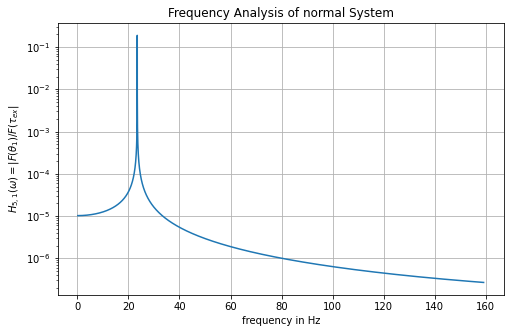

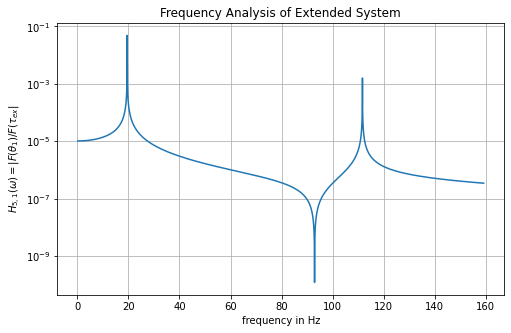

In [22]:
def eigenfrequency(M, K):
    omega_r_sq,X_r = linalg.eig(K,M)
    idx = omega_r_sq.argsort()[::1]  # sorting the eigenvalues
    omega_r_sq = omega_r_sq[idx]
    X_r = X_r[:,idx]
    omega_r = np.sqrt(omega_r_sq.real)
    omega_r_hz = omega_r/2/np.pi
    return omega_r, X_r

def print_eigenfrequency(omega_r, X_r):
    omega_r_hz = omega_r/2/np.pi
    with np.printoptions(precision=2, suppress=True):
        print("Eigenfrequencies as angular frequencies at {0} rad/sec".format(omega_r))
        print("Eigenfrequencies as Hz: {0} Hz".format(omega_r_hz))
        print("Eigenmodes: \n{0}".format(X_r))

def frequency_response(M, K, title, filename):
    omega = 1
    h=np.ndarray(10000)
    i=0
    H = np.zeros((5,5))
    omega = np.linspace(1, 1000, num=10000)
    for omega_i in omega:
        H = linalg.inv(-M*omega_i**2 + K)
        h[i] = np.absolute(H[4,0])  # force at theta_5(=index 4); angle at theta_1(=index 0)
        i+=1
    plt.figure(figsize=(8,5))
    plt.semilogy(omega/2/np.pi,h)
    plt.title(title)
    plt.xlabel('frequency in Hz')
    plt.ylabel(r'$H_{5,1}(\omega) = |F(\theta_1)/F(\tau_{ex}|$')
    plt.grid(True)
    plt.draw()
    # plt.savefig(filename, bbox_inches='tight')

print("######### System with One Flywheel mounted #######")
omega_r, X_r = eigenfrequency(M, K)
print_eigenfrequency(omega_r, X_r)
frequency_response(M,K, "Frequency Analysis of normal System", "frequency_analysis.eps")

print("\n######### extended System with Two Flywheel mounted #######")
omega_r_ex, X_r_ex = eigenfrequency(M_ex, K_ex)
print_eigenfrequency(omega_r_ex, X_r_ex)
frequency_response(M_ex,K_ex, "Frequency Analysis of Extended System", "frequency_analysis_ex.eps")

In [13]:
K[0,0]

797756.8129380475

### Statics - Calculation the System's Stiffness
The total torsion is the sum of the partial torsion at the components. The incremental angle encoder is located close to the motor module. This keeps the deviation very small so we can assume that there is no error of the angle between the motor module and the incremental angle encoder even under full load.

The maximum torsion of the complete test bench -- meaning from the motor module on the one side to the flywheel on the other side -- provides characteristcs which are important for further analysis using the test bench. We calculate the total torsion by 

$$K x_{(r)}=f$$

and use the normed static deflection $H_{5,5, static} = \frac{\theta_{5, static}}{\tau_{ex}}$

In [14]:
H_static = linalg.inv(K)
h = H_static[4,4]   # force at theta_5(=index 4); angle at theta_5(=index 4)
print("H_(4,4,static) = {0:.6f} rad/Nm = {1:.6f}°/Nm".format(h, h*360/2/np.pi))

H_(4,4,static) = 0.000024 rad/Nm = 0.001402°/Nm


### Velocity and Acceleration of Motormodules in Testbench
The motormodule can be described by its torque and maximum rational speed. To gather the system's acceleration behaviour, we consider the moment of inertia of the flywheel which is accelerated by the motor module. We assume that the flywheel is accelerated with maximum torque until the maximum rotational speed of the motor module is reached. 

Using Newton, we come to the motion equation $ \ddot{\theta} J = \tau $. Without considering the limitation due to the maximum speed of the motormodules, we can express the dynamics as:

$$   \ddot{\theta} = \frac{\tau}{J}   \to   \dot{\theta} = \frac{\tau}{J} t   \to   
\theta = \frac{1}{2}\frac{\tau}{J}t^2   \to   t = \sqrt{2 \theta \frac{J}{\tau}}$$

We define the maximum values as

$$ t_{max,deg} = \sqrt{2 \theta_{max} \frac{J}{\tau}}, t_{max,speed} = \frac{\dot{\theta}_{max} J}{\tau} $$

with $\theta_{max}$ being the maximum angle and $\dot{\theta}_{max}$ the maximum permitted speed of the motor module.

We need to consider, that the motor modules are also limited in their angle due to the hardware. Thus, we need to ensure that the maximum angle does not exceed the hardware limiation. In order to accelerate to the maximum possible speed, we also need to consider that there must be enough space left for slowing down the motor module.

In [15]:
class Load:
    def __init__(self, *mass):
        self.inertia_tmp = 0
        for elem in mass:
            self.inertia_tmp += elem.inertia
    def inertia(self, motormodule):
        self.inertia_tmp += motormodule.inertia
        return self.inertia_tmp
            
load = Load(coupling, torque_sensor, coupling, flywheel_big, flywheel_small) # complete load

def t_max_deg(motormodule, load_inertia, theta_max):  
    # time to reach maximum degree without considering speed limit of the motormodule
    return np.sqrt(2*theta_max*load_inertia/motormodule.torque)

def t_max_speed(motormodule, load_inertia, dtheta_max):  # time to reach maximum speed limit of motor module
    return dtheta_max*load_inertia/motormodule.torque

def ddtheta(motormodule, load_inertia):
    return motormodule.torque/load_inertia

def dtheta(motormodule, load_inertia, t):
    dtheta = motormodule.torque/load_inertia*t
    return dtheta
    # return dtheta.clip(0,motormodule.speed_rad)  # clip at max speed of motormodule

def theta(motormodule, load_inertia, t):
    theta = 0.5*motormodule.torque/load_inertia*t**2
    return theta
    # return theta.clip(0,motormodule.max_deflection)  # clip at max revolution angle of motormodule


for mot in [motormodule_S, motormodule_M, motormodule_L, motormodule_XL]:
    theta_max = mot.max_deflection/2
    print("mass inertia load inc. motor: {0:.3f}kg m^2 (for comparison: robot link has 6 kg m^2)".format(load.inertia(mot)))
    print("{0}:".format(mot.name))
    print("max acc: {0:.2f} rad/sec^2".format(ddtheta(mot, load.inertia(mot))))
    print("time to reach 180°: {0:.2f} s\t\tmax speed at 180°: {1:.2f} rad/sek".format(t_max_deg(mot, load.inertia(mot), theta_max), dtheta(mot, load.inertia(mot), t_max_deg(mot, load.inertia(mot), theta_max))))
    print("time to reach max module speed: {0:.2f} s\tmax speed of motormodule: {1:.2f} rad/sek"
         .format(t_max_speed(mot, load.inertia(mot), mot.speed_rad), mot.speed_rad))
    print("")
# print("measurement frequency min: {0} Hz".format(2*dtheta(motormodule_XL, flywheel, t_max)*2**19))

mass inertia load inc. motor: 2.701kg m^2 (for comparison: robot link has 6 kg m^2)
Motormodule S:
max acc: 10.40 rad/sec^2
time to reach 180°: 0.78 s		max speed at 180°: 8.08 rad/sek
time to reach max module speed: 0.61 s	max speed of motormodule: 6.37 rad/sek

mass inertia load inc. motor: 2.703kg m^2 (for comparison: robot link has 6 kg m^2)
Motormodule M:
max acc: 23.96 rad/sec^2
time to reach 180°: 0.51 s		max speed at 180°: 12.27 rad/sek
time to reach max module speed: 0.14 s	max speed of motormodule: 3.38 rad/sek

mass inertia load inc. motor: 2.712kg m^2 (for comparison: robot link has 6 kg m^2)
Motormodule L:
max acc: 38.90 rad/sec^2
time to reach 180°: 0.40 s		max speed at 180°: 15.62 rad/sek
time to reach max module speed: 0.06 s	max speed of motormodule: 2.39 rad/sek

mass inertia load inc. motor: 2.737kg m^2 (for comparison: robot link has 6 kg m^2)
Motormodule XL:
max acc: 83.88 rad/sec^2
time to reach 180°: 0.27 s		max speed at 180°: 22.92 rad/sek
time to reach max modul

In [16]:
motormodule_XL.speed_rad

1.930770485018727

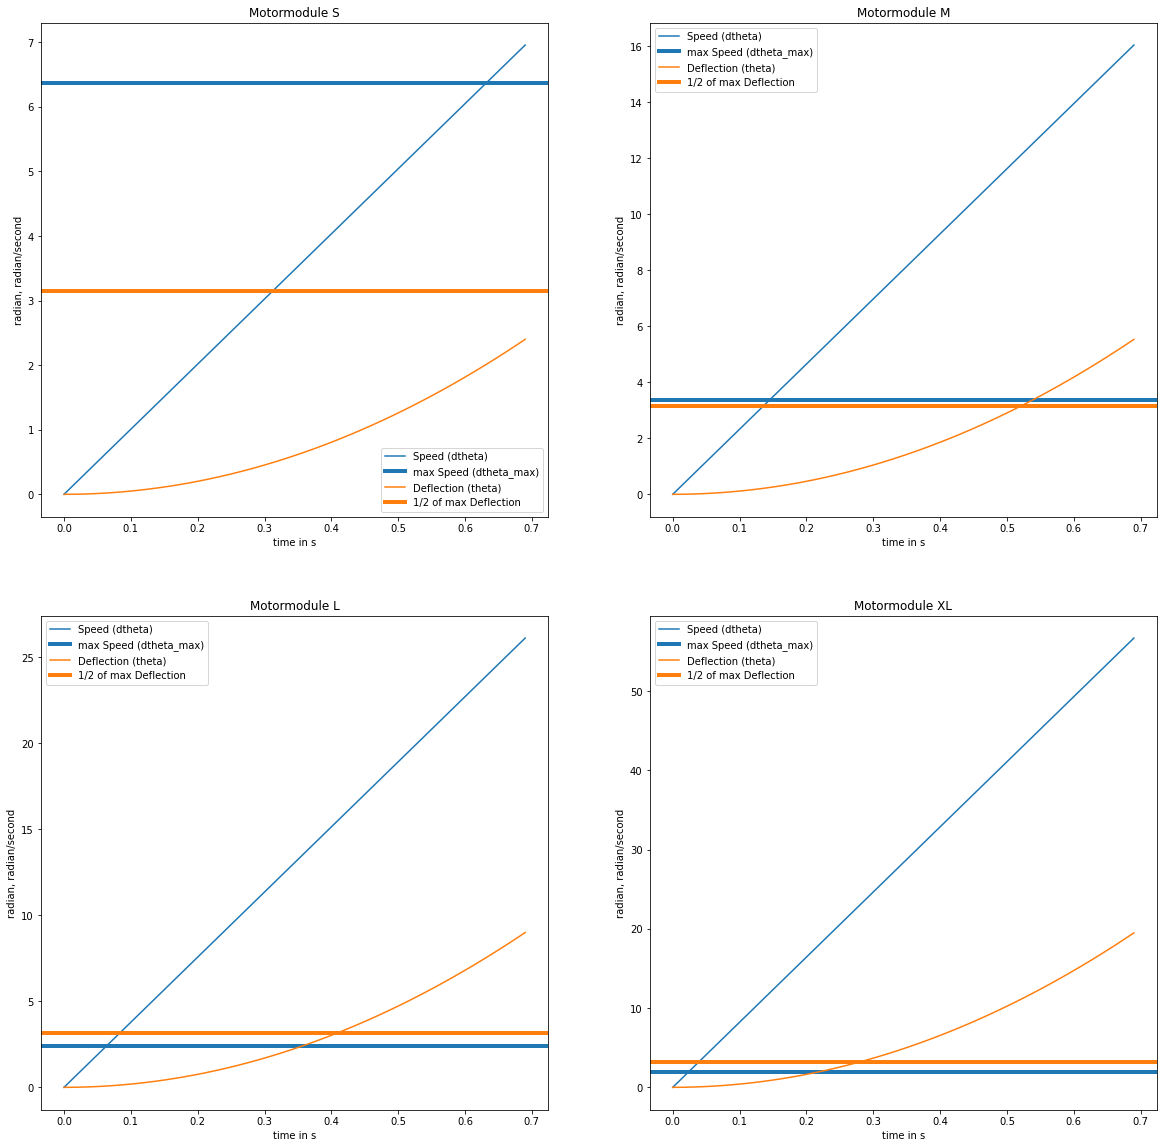

In [17]:
t = np.arange(0, 0.7, 0.01)  # time (start, end, iteration)

plt.rcParams["figure.figsize"]=20,20  # set size to full
i=1
for mot in [motormodule_S, motormodule_M, motormodule_L, motormodule_XL]:
    fig = plt.subplot(2,2,i)
    i=i+1
    fig.plot(t,dtheta(mot, load.inertia(mot), t), label="Speed (dtheta)")
    fig.axhline(mot.speed_rad, label="max Speed (dtheta_max)", color='tab:blue', linewidth=4)
    fig.plot(t,theta(mot, load.inertia(mot), t), label="Deflection (theta)")
    fig.axhline(mot.max_deflection/2, label="1/2 of max Deflection", color='tab:orange', linewidth=4)
    fig.legend()
    fig.set_title(mot.name)
    fig.set_xlabel('time in s')
    fig.set_ylabel('radian, radian/second');
# plt.savefig('acceleration_motor_module.eps', bbox_inches='tight')

### Measure Frequency
As described before, there is a certain time span of how long the the testing procedures last. This section analyses the temporal resolution of the measurements and evaluates the number of data points collecting in this time period. This is important to avoid a shortage of data points in one testing procedure period which would result in lower quality of the result.

We assume that the motor module accelerate with the maximum torque possible. The load inertia is chosen as above. Note that the selected time period is only half of the available angle range. The other half is needed to decelerate before reaching the angle limit of the motor module. The number of cycles $n_{cycles}$ in one testing procedure comes from the cycle time of the PLC:

$$ n_{cycles} = \frac{min(t_{max,deg}, t_{max,speed})}{t_{plc}} $$

$ t_{plc} $ is the cycle time of the plc system, which is the interval in which the plc system writes a new measuring point.

In [18]:
t = []
no_of_cycles = []
plc = PLC_laptop
print("min time for one test drive until reaching max deflection or max motor speed:")
print("cycletime of {0} = {1} µs".format(plc.name, plc.cycletime_us))
for mot in [motormodule_S, motormodule_M, motormodule_L, motormodule_XL]:
    theta_max = mot.max_deflection/2
    dtheta_max = mot.speed_rad
    t.append(min(t_max_deg(mot, load.inertia(mot), theta_max), t_max_speed(mot, load.inertia(mot), dtheta_max)))
    no_of_cycles.append(t[-1]/plc.distributedclock_s)
    print("{0}:\t{1:.4f}s\t => {2:.1f} cycles".format(mot.name, t[-1], no_of_cycles[-1]))

min time for one test drive until reaching max deflection or max motor speed:
cycletime of PLC_laptop = 1000 µs
Motormodule S:	0.6386s	 => 6386.1 cycles
Motormodule M:	0.1468s	 => 1468.2 cycles
Motormodule L:	0.0639s	 => 638.7 cycles
Motormodule XL:	0.0238s	 => 238.2 cycles
